In [145]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [146]:


class Node(object):
    def __init__(self):
        self.feature_index = None
        self.split_point = None
        self.deep = None
        self.left_tree = None
        self.right_tree = None
        self.leaf_class = None


In [147]:


def gini(y, D):
    '''
    计算样本集y下的加权基尼指数
    :param y: 数据样本标签
    :param D: 样本权重
    :return:  加权后的基尼指数
    '''
    unique_class = np.unique(y)
    total_weight = np.sum(D)

    gini = 1
    for c in unique_class:
        gini -= (np.sum(D[y == c]) / total_weight) ** 2

    return gini



In [148]:

def calcMinGiniIndex(a, y, D):
    '''
    计算特征a下样本集y的的基尼指数
    :param a: 单一特征值
    :param y: 数据样本标签
    :param D: 样本权重
    :return:
    '''

    feature = np.sort(a)
    total_weight = np.sum(D)

    split_points = [(feature[i] + feature[i + 1]) / 2 for i in range(feature.shape[0] - 1)]

    min_gini = float('inf')
    min_gini_point = None

    for i in split_points:
        yv1 = y[a <= i]
        yv2 = y[a > i]

        Dv1 = D[a <= i]
        Dv2 = D[a > i]
        gini_tmp = (np.sum(Dv1) * gini(yv1, Dv1) + np.sum(Dv2) * gini(yv2, Dv2)) / total_weight

        if gini_tmp < min_gini:
            min_gini = gini_tmp
            min_gini_point = i

    return min_gini, min_gini_point


In [149]:


def chooseFeatureToSplit(X, y, D):
    '''
    :param X:
    :param y:
    :param D:
    :return: 特征索引, 分割点
    '''
    gini0, split_point0 = calcMinGiniIndex(X[:, 0], y, D)
    gini1, split_point1 = calcMinGiniIndex(X[:, 1], y, D)

    if gini0 > gini1:
        return 1, split_point1
    else:
        return 0, split_point0


In [150]:

def createSingleTree(X, y, D, deep=0):
    '''
    这里以gini指数决策树作为基学习器，限定深度为2
    :param X: 训练集特征
    :param y: 训练集标签
    :param D: 训练样本权重
    :param deep: 树的深度
    :return:
    '''

    node = Node()
    node.deep = deep

    if (deep == 2) | (X.shape[0] <= 2):  # 当前分支下，样本数量小于等于2 或者 深度达到2时，直接设置为叶节点
        pos_weight = np.sum(D[y == 1])
        neg_weight = np.sum(D[y == -1])
        if pos_weight > neg_weight:
            node.leaf_class = 1
        else:
            node.leaf_class = -1

        return node

    feature_index, split_point = chooseFeatureToSplit(X, y, D)

    node.feature_index = feature_index
    node.split_point = split_point

    left = X[:, feature_index] <= split_point
    right = X[:, feature_index] > split_point

    node.left_tree = createSingleTree(X[left, :], y[left], D[left], deep + 1)
    node.right_tree = createSingleTree(X[right, :], y[right], D[right], deep + 1)

    return node



In [151]:

def predictSingle(tree, x):
    '''
    基于基学习器，预测单个样本
    :param tree:
    :param x:
    :return:
    '''
    if tree.leaf_class is not None:
        return tree.leaf_class

    if x[tree.feature_index] > tree.split_point:
        return predictSingle(tree.right_tree, x)
    else:
        return predictSingle(tree.left_tree, x)



In [152]:

def predictBase(tree, X):
    '''
    基于基学习器预测所有样本
    :param tree:
    :param X:
    :return:
    '''
    result = []

    for i in range(X.shape[0]):
        result.append(predictSingle(tree, X[i, :]))

    return np.array(result)


In [153]:


def adaBoostTrain(X, y, tree_num=5):
    '''
    以深度为2的决策树作为基学习器，训练adaBoost
    :param X:
    :param y:
    :param tree_num:
    :return:
    '''
    D = np.ones(y.shape) / y.shape  # 初始化权重

    trees = []  # 所有基学习器
    a = []  # 基学习器对应权重


    for _ in range(tree_num):
        tree = createSingleTree(X, y, D)

        hx = predictBase(tree, X)
        err_rate = np.sum(D[hx != y])

        at = np.log((1 - err_rate) / max(err_rate, 1e-16)) / 2

        trees.append(tree)
        a.append(at)

        if (err_rate > 0.5) | (err_rate == 0):  # 错误率大于0.5 或者 错误率为0时，则直接停止
            break

        # 更新每个样本权重

        D = D * np.exp(-y*hx*at)
        D = D / np.sum(D)

    return trees, a


$$
\alpha_{m}=\frac{1}{2} \log \frac{1-e_{m}}{e_{m}}
$$

$$
w_{m+1, i}=\frac{w_{m i}}{Z_{m}} \exp \left(-\alpha_{m} y_{i} G_{m}\left(x_{i}\right)\right)
$$

In [154]:


def adaBoostPredict(X, trees, a):
    agg_est = np.zeros((X.shape[0],))

    for tree, am in zip(trees, a):
        agg_est += am * predictBase(tree, X)

    result = np.ones((X.shape[0],))

    result[agg_est < 0] = -1

    return result.astype(int)



In [155]:

def pltAdaBoostDecisionBound(X_, y_, trees, a):
    pos = y_ == 1
    neg = y_ == -1
    x_tmp = np.linspace(0, 1, 600)
    y_tmp = np.linspace(-0.2, 0.7, 600)

    X_tmp, Y_tmp = np.meshgrid(x_tmp, y_tmp)

    Z_ = adaBoostPredict(np.c_[X_tmp.ravel(), Y_tmp.ravel()], trees, a).reshape(X_tmp.shape)
    plt.contour(X_tmp, Y_tmp, Z_, [0], colors='orange', linewidths=1)

    plt.scatter(X_[pos, 0], X_[pos, 1], label='1', color='c')
    plt.scatter(X_[neg, 0], X_[neg, 1], label='0', color='lightcoral')
    plt.legend()
    plt.show()


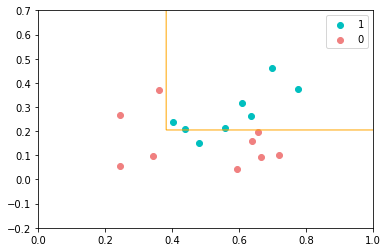

In [156]:

data_path = "watermelon3_0a_Ch.txt"

data = pd.read_table(data_path, delimiter=' ')

X = data.iloc[:, :2].values
y = data.iloc[:, 2].values

y[y == 0] = -1

trees, a= adaBoostTrain(X, y,tree_num=1)

pltAdaBoostDecisionBound(X, y, trees, a)

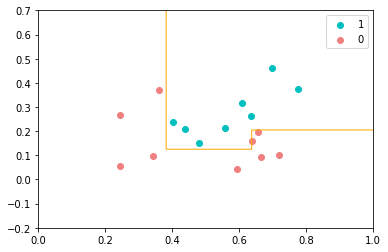

In [157]:
trees, a= adaBoostTrain(X, y,tree_num=3)

pltAdaBoostDecisionBound(X, y, trees, a)

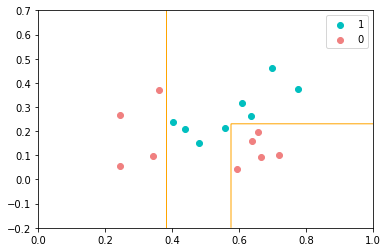

In [158]:
trees, a= adaBoostTrain(X, y,tree_num=5)

pltAdaBoostDecisionBound(X, y, trees, a)